In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import os
import pandas as pd

class TextDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence, target = self.sequences[idx]
        return torch.tensor(sequence), torch.tensor(target)
# sys.path.append("..")
# from functions import build_vocab, encode_sequences
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import re
from collections import Counter
from transformers import BertTokenizer
import pandas as pd
import os
import concurrent.futures
from functools import partial

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def clean_text(text):
    if not isinstance(text, str):
        text = str(text)
    text = text.lower().strip()
    text = re.sub(r'(.)\1+', r'\1\1', text)
    text = re.sub(r'https?://\S+', '', text)
    text = re.sub(r'@\w+', 'name', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text

def tokenize_text(text, tokenizer):
    cleaned_text = clean_text(text)
    tokens = tokenizer.tokenize(cleaned_text)

    return tokens

def build_vocab(texts, tokenizer):
    with concurrent.futures.ThreadPoolExecutor() as executor:
        tokenize_fn = partial(tokenize_text, tokenizer=tokenizer)
        tokenized_texts = list(executor.map(tokenize_fn, texts))

    all_tokens = [token for text in tokenized_texts for token in text]
    token_counts = Counter(all_tokens)
    sorted_tokens = sorted(token_counts, key=token_counts.get, reverse=True)
    if sorted_tokens:
        print(f"Most common tokens: {sorted_tokens[:20]}")
    else:
        print("No tokens found")

    word_to_idx = tokenizer.vocab
    return word_to_idx, tokenized_texts

def process_sequence(tokens, word_to_idx, max_seq_length, padding_idx, unk_idx):
    if not tokens:
        return [], [], []

    encoded_tokens = [word_to_idx.get(word, unk_idx) for word in tokens]
    sequences = []
    lengths = []
    targets = []

    for i in range(max_seq_length, len(encoded_tokens)):
        sequence = encoded_tokens[i - max_seq_length:i]
        target = encoded_tokens[i]

        if len(sequence) < max_seq_length:
            sequence += [padding_idx] * (max_seq_length - len(sequence))

        sequences.append(sequence)
        lengths.append(min(len(sequence), max_seq_length))
        targets.append(target)

    return sequences, lengths, targets

def encode_sequences(tokenized_texts, word_to_idx, max_seq_length=10, padding_token='[PAD]', unk_token='[UNK]', max_seq=500000):
    word_to_idx.setdefault(padding_token, len(word_to_idx))
    word_to_idx.setdefault(unk_token, len(word_to_idx))

    padding_idx = word_to_idx[padding_token]
    unk_idx = word_to_idx[unk_token]

    process_fn = partial(process_sequence,
                        word_to_idx=word_to_idx,
                        max_seq_length=max_seq_length,
                        padding_idx=padding_idx,
                        unk_idx=unk_idx)

    sequences, lengths, targets = [], [], []
    with concurrent.futures.ThreadPoolExecutor() as executor:
        results = list(executor.map(process_fn, tokenized_texts))

    for seq, length, target in results:
        sequences.extend(seq)
        lengths.extend(length)
        targets.extend(target)

        # Limit the total number of sequences to max_sequences
        if len(sequences) >= max_seq:
            break

    if sequences:
        print(f"Number of sequences generated: {len(sequences)}")
        print(f"Sample sequence: {sequences[0]}")
        print(f"Sample target: {targets[0]}")
    else:
        print("No sequences generated")

    return sequences, lengths, targets

folder_path = '/content/drive/MyDrive/Capstone NWP/X'
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
csv_files = sorted(csv_files)[:10]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [4]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 11.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2


In [5]:
from datasets import load_dataset
import pandas as pd
import os
from transformers import BertTokenizer

def get_data():
    try:
        dataset = load_dataset("wikipedia", "20220301.en", split="train[:10000]")
        texts = [{'data': article['text']} for article in dataset]
        df = pd.DataFrame(texts)
        # os.makedirs('data', exist_ok=True)
        # df.to_csv('data/wiki.csv', index=False)
        output_dir = '/content/drive/MyDrive/Capstone NWP/data'
        os.makedirs(output_dir, exist_ok=True)
        df.to_csv(os.path.join(output_dir, 'wiki.csv'), index=False)
        print(f"Saved {len(texts)} Wikipedia articles to data/wiki.csv")
    except Exception as e:
        print(f"Error getting data: {str(e)}")

def process_article(text, tokenizer, sequence_length):
    tokens = tokenizer.encode(text, add_special_tokens=True, max_length=256, truncation=True)
    sequences = []
    for i in range(0, len(tokens) - sequence_length):
        sequence = tokens[i:i + sequence_length]
        target = tokens[i + sequence_length]
        sequences.append((sequence, target))
    return sequences

def load_data(sequence_length=10):
    try:
        df = pd.read_csv('/content/drive/MyDrive/Capstone NWP/data/wiki.csv')
        texts = [row['data'] for _, row in df.iterrows()]
        print(df.head())
        print(f"Loaded {len(texts)} Wikipedia articles from data/wiki.csv")

        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        process_fn = partial(process_article, tokenizer=tokenizer, sequence_length=sequence_length)

        all_sequences = []
        with concurrent.futures.ThreadPoolExecutor() as executor:
            for sequences in executor.map(process_fn, texts):
                all_sequences.extend(sequences)

        print(f"Created {len(all_sequences)} sequences of length {sequence_length}")
        return all_sequences
    except Exception as e:
        print(f"Error loading data: {str(e)}")
        return []

get_data()

wikiseq = load_data()

def load_csv_file(file_path):
    try:
        return pd.read_csv(file_path)
    except Exception as e:
        print(f"Error loading file {file_path}: {str(e)}")
        return None

dfs = []
with concurrent.futures.ThreadPoolExecutor() as executor:
    file_paths = [os.path.join(folder_path, file) for file in csv_files]
    results = executor.map(load_csv_file, file_paths)
    dfs.extend([df for df in results if df is not None])

if wikiseq:
    wiki_df = pd.DataFrame({'text': [str(seq[0]) for seq in wikiseq]})
    dfs.append(wiki_df)

if dfs:
    df = pd.concat(dfs, ignore_index=True)
    texts = df['text'].tolist()

    # Split data equally between wiki and other data
    wiki_texts = texts[:len(texts)//2]
    other_texts = texts[len(texts)//2:]

    word_to_idx, tokenized_texts = build_vocab(wiki_texts + other_texts, tokenizer)
    sequences, lengths, targets = encode_sequences(tokenized_texts, word_to_idx, max_seq=500000)

    print(f"Vocabulary size: {len(word_to_idx)}")
    print(f"Number of sequences: {len(sequences)}")
else:
    print("No data loaded")


README.md:   0%|          | 0.00/16.0k [00:00<?, ?B/s]

wikipedia.py:   0%|          | 0.00/36.7k [00:00<?, ?B/s]

The repository for wikipedia contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/wikipedia.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


train-00000-of-00041.parquet:   0%|          | 0.00/1.04G [00:00<?, ?B/s]

train-00001-of-00041.parquet:   0%|          | 0.00/705M [00:00<?, ?B/s]

train-00002-of-00041.parquet:   0%|          | 0.00/558M [00:00<?, ?B/s]

train-00003-of-00041.parquet:   0%|          | 0.00/491M [00:00<?, ?B/s]

train-00004-of-00041.parquet:   0%|          | 0.00/431M [00:00<?, ?B/s]

train-00005-of-00041.parquet:   0%|          | 0.00/391M [00:00<?, ?B/s]

train-00006-of-00041.parquet:   0%|          | 0.00/366M [00:00<?, ?B/s]

train-00007-of-00041.parquet:   0%|          | 0.00/326M [00:00<?, ?B/s]

train-00008-of-00041.parquet:   0%|          | 0.00/329M [00:00<?, ?B/s]

train-00009-of-00041.parquet:   0%|          | 0.00/312M [00:00<?, ?B/s]

train-00010-of-00041.parquet:   0%|          | 0.00/267M [00:00<?, ?B/s]

train-00011-of-00041.parquet:   0%|          | 0.00/247M [00:00<?, ?B/s]

train-00012-of-00041.parquet:   0%|          | 0.00/229M [00:00<?, ?B/s]

train-00013-of-00041.parquet:   0%|          | 0.00/248M [00:00<?, ?B/s]

train-00014-of-00041.parquet:   0%|          | 0.00/222M [00:00<?, ?B/s]

train-00015-of-00041.parquet:   0%|          | 0.00/236M [00:00<?, ?B/s]

train-00016-of-00041.parquet:   0%|          | 0.00/215M [00:00<?, ?B/s]

train-00017-of-00041.parquet:   0%|          | 0.00/229M [00:00<?, ?B/s]

train-00018-of-00041.parquet:   0%|          | 0.00/241M [00:00<?, ?B/s]

train-00019-of-00041.parquet:   0%|          | 0.00/228M [00:00<?, ?B/s]

train-00020-of-00041.parquet:   0%|          | 0.00/214M [00:00<?, ?B/s]

train-00021-of-00041.parquet:   0%|          | 0.00/255M [00:00<?, ?B/s]

train-00022-of-00041.parquet:   0%|          | 0.00/226M [00:00<?, ?B/s]

train-00023-of-00041.parquet:   0%|          | 0.00/226M [00:00<?, ?B/s]

train-00024-of-00041.parquet:   0%|          | 0.00/192M [00:00<?, ?B/s]

train-00025-of-00041.parquet:   0%|          | 0.00/218M [00:00<?, ?B/s]

train-00026-of-00041.parquet:   0%|          | 0.00/212M [00:00<?, ?B/s]

train-00027-of-00041.parquet:   0%|          | 0.00/206M [00:00<?, ?B/s]

train-00028-of-00041.parquet:   0%|          | 0.00/199M [00:00<?, ?B/s]

train-00029-of-00041.parquet:   0%|          | 0.00/219M [00:00<?, ?B/s]

train-00030-of-00041.parquet:   0%|          | 0.00/214M [00:00<?, ?B/s]

train-00031-of-00041.parquet:   0%|          | 0.00/216M [00:00<?, ?B/s]

train-00032-of-00041.parquet:   0%|          | 0.00/200M [00:00<?, ?B/s]

train-00033-of-00041.parquet:   0%|          | 0.00/203M [00:00<?, ?B/s]

train-00034-of-00041.parquet:   0%|          | 0.00/201M [00:00<?, ?B/s]

train-00035-of-00041.parquet:   0%|          | 0.00/192M [00:00<?, ?B/s]

train-00036-of-00041.parquet:   0%|          | 0.00/199M [00:00<?, ?B/s]

train-00037-of-00041.parquet:   0%|          | 0.00/195M [00:00<?, ?B/s]

train-00038-of-00041.parquet:   0%|          | 0.00/203M [00:00<?, ?B/s]

train-00039-of-00041.parquet:   0%|          | 0.00/192M [00:00<?, ?B/s]

train-00040-of-00041.parquet:   0%|          | 0.00/185M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/6458670 [00:00<?, ? examples/s]

Saved 10000 Wikipedia articles to data/wiki.csv
                                                data
0  Anarchism is a political philosophy and moveme...
1  Autism is a neurodevelopmental disorder charac...
2  Albedo (; ) is the measure of the diffuse refl...
3  A, or a, is the first letter and the first vow...
4  Alabama () is a state in the Southeastern regi...
Loaded 10000 Wikipedia articles from data/wiki.csv
Created 2404425 sequences of length 10
Most common tokens: ['name', 'i', 'to', 'the', 'a', 'you', 'and', 'my', '##t', 'is', 'it', 'for', 'in', '##s', 'of', 'that', 'im', 'on', 'me', 'have']
Number of sequences generated: 500001
Sample sequence: [2003, 6314, 2008, 2002, 2064, 2102, 10651, 2010, 9130, 2011]
Sample target: 3793
Vocabulary size: 30522
Number of sequences: 500001


In [6]:
from torch.utils.data import DataLoader, Dataset
import torch
from sklearn.model_selection import train_test_split
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class TextDataset(Dataset):
    def __init__(self, sequences, lengths, targets):
        self.sequences = sequences
        self.lengths = lengths
        self.targets = targets

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return torch.tensor(self.sequences[idx]), torch.tensor(self.lengths[idx]), torch.tensor(self.targets[idx])

class NextWordLSTM(nn.Module):
    def __init__(self, vocab_size=30522, embed_size=128, hidden_size=256, num_layers=1, repetition_penalty=1.1):
        super(NextWordLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=0)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)
        self.repetition_penalty = repetition_penalty

    def forward(self, x, lengths):
        x = self.embedding(x)

        packed_input = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        packed_out, (ht, ct) = self.lstm(packed_input)

        lstm_out, _ = pad_packed_sequence(packed_out, batch_first=True)
        lstm_out = lstm_out[torch.arange(lstm_out.size(0)), lengths - 1]
        out = self.fc(lstm_out)



        # repetition penalty
        if self.repetition_penalty != 1.0:
            for i in range(out.size(0)):
                for j in range(lengths[i].item()):
                    token_id = x[i, j].argmax().item()
                    if token_id != 0: # padding token
                        out[i, token_id] -= torch.log(torch.tensor(self.repetition_penalty, device=out.device))


        return out

train_sequences, val_sequences, train_lengths, val_lengths, train_targets, val_targets = train_test_split(
    sequences, lengths, targets, test_size=0.2, random_state=42)

train_dataset = TextDataset(train_sequences, train_lengths, train_targets)
val_dataset = TextDataset(val_sequences, val_lengths, val_targets)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)


In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn

def validate_model(model, val_loader, criterion):
    model.eval()
    total_loss = 0
    total_correct = 0
    with torch.no_grad():  # Disable gradient computation for validation
        for sequences, lengths, targets in val_loader:
            sequences = sequences.to(device)
            lengths = lengths.cpu()
            targets = targets.to(device)

            outputs = model(sequences, lengths)
            loss = criterion(outputs, targets)
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == targets).sum().item()

    avg_loss = total_loss / len(val_loader)
    avg_acc = total_correct / len(val_loader.dataset)
    return avg_loss, avg_acc


def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20, patience=2):
    train_losses = []
    val_losses = []
    val_accuracies = []
    best_val_loss = float('inf')
    patience_counter = 0
    best_model = None
    model.dropout = nn.Dropout(p=0.3)

    for epoch in range(num_epochs):
        total_loss = 0
        model.train()

        for batch_idx, (sequences, lengths, targets) in enumerate(train_loader):
            sequences = sequences.to(device)
            lengths = lengths.cpu()
            targets = targets.to(device)

            outputs = model(sequences, lengths)
            loss = criterion(outputs, targets)


            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            if (batch_idx + 1) % 100 == 0:
                current_loss = total_loss / (batch_idx + 1)
                print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Current Loss: {current_loss:.4f}')

        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        val_loss, val_acc = validate_model(model, val_loader, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f'Epoch [{epoch+1}/{num_epochs}] completed:')
        print(f'  - Average Train Loss: {avg_train_loss:.4f}')
        print(f'  - Validation Loss: {val_loss:.4f}')
        print(f'  - Validation Accuracy: {val_acc:.4f}')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model = model
            print('new best model')
        else:
            patience_counter += 1
            print('model worse.')
            if patience_counter >= patience:
                print("early stoppíng")
                break

    model = best_model
    return train_losses, val_losses, val_accuracies


model = NextWordLSTM(vocab_size=len(tokenizer.vocab), embed_size=128, hidden_size=256, num_layers=1).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)

print("Starting training...")
train_losses, val_losses, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)


Starting training...
Epoch [1/10], Batch [100/12500], Current Loss: 8.5497
Epoch [1/10], Batch [200/12500], Current Loss: 8.0297
Epoch [1/10], Batch [300/12500], Current Loss: 7.8335
Epoch [1/10], Batch [400/12500], Current Loss: 7.7136
Epoch [1/10], Batch [500/12500], Current Loss: 7.6108
Epoch [1/10], Batch [600/12500], Current Loss: 7.5402
Epoch [1/10], Batch [700/12500], Current Loss: 7.4776
Epoch [1/10], Batch [800/12500], Current Loss: 7.4268
Epoch [1/10], Batch [900/12500], Current Loss: 7.3784
Epoch [1/10], Batch [1000/12500], Current Loss: 7.3378
Epoch [1/10], Batch [1100/12500], Current Loss: 7.2947
Epoch [1/10], Batch [1200/12500], Current Loss: 7.2523
Epoch [1/10], Batch [1300/12500], Current Loss: 7.2163
Epoch [1/10], Batch [1400/12500], Current Loss: 7.1843
Epoch [1/10], Batch [1500/12500], Current Loss: 7.1564
Epoch [1/10], Batch [1600/12500], Current Loss: 7.1310
Epoch [1/10], Batch [1700/12500], Current Loss: 7.1062
Epoch [1/10], Batch [1800/12500], Current Loss: 7.082

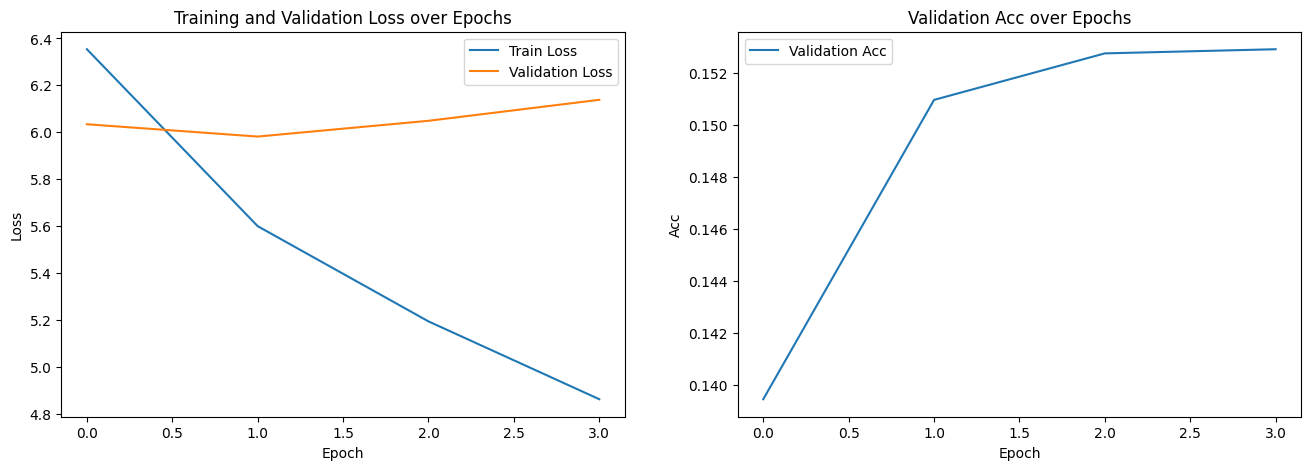

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(16, 5))

axs[0].plot(train_losses, label="Train Loss")
axs[0].plot(val_losses, label="Validation Loss")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].set_title("Training and Validation Loss over Epochs")
axs[0].legend()

axs[1].plot(val_accuracies, label="Validation Acc")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Acc")
axs[1].set_title("Validation Acc over Epochs")
axs[1].legend()

plt.show()

In [ ]:
def predict_next_word(model, sequence, idx_to_word, word_to_idx, seq_length=6):
    model.eval()

    padded_sequence = sequence[-seq_length:]
    padded_sequence += [word_to_idx['[PAD]']] * (seq_length - len(padded_sequence))

    sequence_tensor = torch.tensor(padded_sequence).unsqueeze(0).to(device)
    lengths = torch.tensor([min(len(sequence), seq_length)], dtype=torch.int64).cpu()

    with torch.no_grad():
        output = model(sequence_tensor, lengths)

        predicted_idx = torch.argmax(output, dim=1).item()

    return idx_to_word.get(predicted_idx, '[UNK]')

idx_to_word = {idx: word for word, idx in word_to_idx.items()}

short_sequences = [
    "hello",
    "hi",
    "the",
    "a",
    "in",
    "at",
    "on",
    "is",
    "am",
    "i",
    "you",
    "are",
    "this",
    "that",
    "these",
    "those"
]

long_sequences = [
    "what year is it right now and",
    "how are you doing today my friend",
    "the quick brown fox jumps over the",
    "once upon a time in a faraway",
    "to be or not to be that",
    "i have a dream that one day",
    "the sun is shining brightly in the",
    "all you need is love and more",
    "life is like a box of chocolates",
    "in the beginning there was nothing but",
    "the world is a book and those",
    "i think therefore i am",
    "the only thing we have to fear",
    "believe you can and you're halfway",
    "the greatest glory in living lies",
    "it does not matter how slowly you go",
    "success is not final failure is not",
    "don't watch the clock do what it does",
    "keep your eyes on the stars and not",
    "you have not lived today until you have",
    "the best way to predict your future",
    "the future belongs to those who believe",
    "the biggest risk is not taking any risk",
    "you miss 100 of the shots you don't take",
    "i have not failed i've just found",
    "success is walking from failure to failure",
    "you are never too old to set another goal",
    "the biggest adventure you can take is",
    "the best revenge is massive success",
    "do something today that your future self",
    "you don't have to be great to start but",
    "you have to start to be great",
    "the only way to do great work is to",
    "you can't use up creativity the more",
    "you use it the more you have",
    "creativity is intelligence having fun",
    "imagination is more important than knowledge",
    "knowledge is limited imagination encircles",
    "the true sign of intelligence is not knowledge",
    "but imagination",
    "imagination is the beginning of creation",
    "you can imagine it you can achieve it",
    "if you can imagine it you can create it",
    "imagination is the key to success",
    "success is the sum of small efforts",
    "repeated day in and day out",
    "the way to get started is to quit talking",
    "and begin doing",
    "the secret of success is not doing your own",
    "work but doing the work of the one",
    "above you",
    "the secret of success is constancy to purpose",
    "the secret of success is not in doing your own",
    "in the beginning there was nothing but"
]

print("\nPredictions for short sequences:")
for sequence in short_sequences:
    indata = [word_to_idx.get(word, word_to_idx['[UNK]']) for word in sequence.split()]
    predicted_word = predict_next_word(model, indata, idx_to_word, word_to_idx)
    print(f"'{sequence}' -> '{predicted_word}'")

print("\nPredictions for long sequences:")
for sequence in long_sequences:
    indata = [word_to_idx.get(word, word_to_idx['[UNK]']) for word in sequence.split()]
    predicted_word = predict_next_word(model, indata, idx_to_word, word_to_idx)
    print(f"'{sequence}' -> '{predicted_word}'")



Predictions for short sequences:
'hello' -> 'to'
'hi' -> '##hi'
'the' -> 'other'
'a' -> 'few'
'in' -> 'the'
'at' -> 'the'
'on' -> 'the'
'is' -> 'the'
'am' -> 'i'
'i' -> 'hope'
'you' -> 'can'
'are' -> 'you'
'this' -> 'morning'
'that' -> '##s'
'these' -> 'days'
'those' -> 'days'

Predictions for long sequences:
'what year is it right now and' -> 'i'
'how are you doing today my friend' -> 'is'
'the quick brown fox jumps over the' -> 'weekend'
'once upon a time in a faraway' -> '##t'
'to be or not to be that' -> 'way'
'i have a dream that one day' -> 'weekend'
'the sun is shining brightly in the' -> 'same'
'all you need is love and more' -> 'than'
'life is like a box of chocolates' -> '##ie'
'in the beginning there was nothing but' -> 'i'
'the world is a book and those' -> 'funny'
'i think therefore i am' -> 'going'
'the only thing we have to fear' -> 'for'
'believe you can and you're halfway' -> '##y'
'the greatest glory in living lies' -> 'and'
'it does not matter how slowly you go' -> 